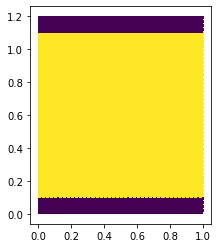

------------------- Start compiler output ------------------------
/tmp/tmp4lh7nhmh/dolfin_subdomain_58a924e22d0b87826f30f9c659b7d0c2.cpp: In member function 'virtual bool dolfin::dolfin_subdomain_58a924e22d0b87826f30f9c659b7d0c2::inside(Eigen::Ref<const Eigen::Matrix<double, -1, 1> >, bool) const':
/tmp/tmp4lh7nhmh/dolfin_subdomain_58a924e22d0b87826f30f9c659b7d0c2.cpp:64:184: error: expected ';' before ')' token
          return (on_boundary and near(x[0],0.,tol) and x[1]<0.1 ) or  (on_boundary and near(x[0],0.,tol) and 1.1<x[1] and x[1]<1.2) or (on_boundary and near(x[0],1.,tol) and x[1]<0.1)) or (on_boundary and near(x[0],1.,tol) and 1.1<x[1] and x[1]<1.2));
                                                                                                                                                                                        ^
/tmp/tmp4lh7nhmh/dolfin_subdomain_58a924e22d0b87826f30f9c659b7d0c2.cpp:64:184: error: expected primary-expression before ')' token

------------

RuntimeError: Unable to compile C++ code with dijitso

In [3]:
# Import packages
import numpy as np
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
from ufl import nabla_div
%matplotlib inline

# Generate the mesh
length = 1.; width = 1.2 #fluido + solido
length_fluid = 1; width_fluid = 1
N = 8 # use positive integer values
mesh = RectangleMesh(Point(0, 0), Point(length, width), N*10, N*12, "right/left")

# Define function spaces for the pressure and the displacement
P2 = VectorElement("Lagrange", mesh.ufl_cell(), 2) #desplazamiento -> vector
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1) #fluido en presion -> escalar
W = FunctionSpace(mesh, MixedElement([P2, P1]))

# partition of the computational domain
tol = 1e-10
fluid_domain = CompiledSubDomain('(fabs(x[0]-0.5) < L0/2. + tol) and (fabs(x[1]-0.6) < L1/2. + tol)', L0=length_fluid, L1=width_fluid, tol=tol)
domain_markers = MeshFunction('size_t', mesh, mesh.topology().dim())
domain_markers.set_all(1) # 1 = dominio solido
fluid_domain.mark(domain_markers, 2) # 2 = dominio fluido
dx = Measure('dx', domain=mesh, subdomain_data=domain_markers)
plot(domain_markers)
plt.show()

# partition of the boundary 
tol = 1e-5
clamped_boundary = CompiledSubDomain('(on_boundary and near(x[0],0.,tol) and x[1]<0.1 ) or  (on_boundary and near(x[0],0.,tol) and 1.1<x[1] and x[1]<1.2) or (on_boundary and near(x[0],1.,tol) and x[1]<0.1)) or (on_boundary and near(x[0],1.,tol) and 1.1<x[1] and x[1]<1.2))', tol=tol)
# x=0 y=[0, 0.1]
#  x=0 y=[1.1, 1.2]
#  x=1 y=[0, 0.1]
#   x=1 y=[1.1, 1.2]


traction_boundary = CompiledSubDomain(' ( on_boundary and near(x[1],L21,tol) ) or ( on_boundary and near(x[1],L22,tol) )', L21=0., L22=1.2, tol=tol) #frontera de traccion
#(0,0) -> (1,0) recta y=0
#(0., 1.2) -> (1, 1.2) recta y=1.2

coupling_boundary = CompiledSubDomain(' ( on_boundary and near(x[1],L31,tol) ) or ( on_boundary and near(x[1],L32,tol) )', L31=0.1, L32=1.1, tol=tol) #frontera de traccion
                                   
#(0, 0.1) -> (1, 0.1) y=0.1
#(0, 1.1) -> (1, 1.1) y=1.1

boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
boundary_markers.set_all(0)
clamped_boundary.mark(boundary_markers, 1) # empotramiento = 1
traction_boundary.mark(boundary_markers, 2) #traccion = 2
coupling_boundary.mark(boundary_markers, 3) #acoplamiento = 3
ds = Measure('ds', domain=mesh, subdomain_data=boundary_markers) #frontera exterior
dS = Measure('dS', domain=mesh, subdomain_data=boundary_markers) # frontera interior (acople)

#Define the variational problem
(u, p) = TrialFunctions(W)
(v, q) = TestFunctions(W)

# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)

# Frequency
omega = 2*np.pi*1.0
    
# Physical constants for the solid   
rho_fluid = 0.2
c = 1.

# Physical constants for the solid
rho = 1.
beta = 1.25
lambda_ = beta
mu = 1
d = u.geometric_dimension()  # space dimension

def sigma(u):
    return lambda_*nabla_div(u)*Identity(d) + 2*mu*epsilon(u)

# Define a
n = FacetNormal(mesh)
a = -omega**2*rho*inner(u, v)*dx(1) + inner(sigma(u), epsilon(v))*dx(1) \
    -omega**2*(1./(rho_fluid*c**2))*p*q*dx(2) + 1./rho_fluid*inner(grad(p),grad(q))*dx(2) \
    - p('+')*inner(v('+'),n('+'))*dS(3) -omega**2*q('+')*inner(u('+'),n('+'))*dS(3)

# Define L
f = Constant((0, 1))
L = dot(f, v)*ds(2)

#Define boundary conditions (just dirichlet) -> empotramiento: solo la u
bc = DirichletBC(W.sub(0), Constant((0, 0)), boundary_markers, 1)


# Assemble
A = assemble(a, keep_diagonal=True)
b = assemble(L)

# Apply the boundary conditions
bc.apply(A)
bc.apply(b)

# Remove the null rows
A.ident_zeros()

# Compute solution: solve the variational problem
w = Function(W)
solve(A, w.vector(), b)
(u,p) = split(w)

# Plot the Finite Element approximation
def plot_solution(u):
    '''plot solution of FEM-based simulation'''
    fig = plt.figure(figsize=(10,10))
    fig = plot(u)
    plt.xlabel(r'$x$ / m')
    plt.ylabel(r'$y$ / m')
    plt.colorbar(fig, fraction=0.038, pad=0.04);
    
# Plot vector field   
plot_solution(u)

# Plot the pressure field
plot_solution(p)